In [1]:
import polars as pl
import numpy as np

# Dependency Detection + Violations

In [2]:
# This is the same dataset as used in 
# the demo by Microsoft: https://learn.microsoft.com/en-us/fabric/data-science/semantic-link-validate-data
# However, dsds will be an open source package based on Polars, not
# FabricDataFrame, which is a Microsoft product.
df = pl.read_parquet("../data/dunnhumby.parquet")
df.head()

household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
i16,i64,i16,i32,i32,f32,i32,f32,i16,i8,i8,i8
2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0,0
2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0,0
2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0,0
2375,26984851472,1,1082185,1,1.21,364,0.0,1631,1,0,0
2375,26984851472,1,8160430,1,1.5,364,-0.39,1631,1,0,0


In [3]:
import dsds.diagnosis as dia
print(df.shape)
entropy, tree = dia.dependency_detection(df, threshold=0.015)

INFO:dsds.diagnosis:Detecting dependency for all columns in dataframe. A total of 66 comparisons will be done.


(2595732, 12)


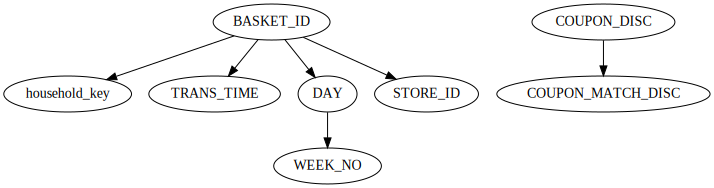

In [4]:
tree

In [5]:
violations = dia.dependency_violation(df, entropy, threshold=0.05)

In [6]:
with pl.Config(fmt_str_lengths=50):
    for k, v in violations.items():
        print(k)
        print(v)

COUPON_MATCH_DISC-COUPON_DISC
shape: (6, 4)
┌──────────────────────────┬───────┬───────────────────────────────┬───────────────────────────────┐
│ Column Name: COUPON_DISC ┆ count ┆ Col COUPON_MATCH_DISC: Value  ┆ Reason                        │
│ ---                      ┆ ---   ┆ & Count                       ┆ ---                           │
│ i8                       ┆ u32   ┆ ---                           ┆ str                           │
│                          ┆       ┆ list[struct[2]]               ┆                               │
╞══════════════════════════╪═══════╪═══════════════════════════════╪═══════════════════════════════╡
│ -5                       ┆ 180   ┆ [{0,179}, {-5,1}]             ┆ `COUPON_DISC` should uniquely │
│                          ┆       ┆                               ┆ determine `COUPON_MA…         │
│ -4                       ┆ 332   ┆ [{0,331}, {-2,1}]             ┆ `COUPON_DISC` should uniquely │
│                          ┆       ┆           

# String Outliers

In [7]:
df = pl.read_csv("../data/providers.csv")
outliers = dia.str_len_outliers(df, (0.01, 0.99))

In [8]:
# We found the 4 digit zip codes, Addresses that are too short, rare city names, etc., 
# which could be potential problems
# by just string length statistics
outliers

Feature,Total Unique Values,Has Null,1.0-Percentile Length,99.0-Percentile Length,Avg Length,Median Length,Outliers,Outlier Count
str,u32,bool,u32,u32,f64,u32,list[str],u32
"""NAME""",5766,false,14,26,19.292741,19,"[""María Soledad68 Dávila115"", ""Juan Carlos348 Mascareñas995"", … ""Jc393 Koss676""]",30
"""SPECIALITY""",69,false,8,38,17.27959,16,"[""UROLOGY"", ""REGISTERED DIETITIAN OR NUTRITION PROFESSIONAL""]",2
"""ADDRESS""",1006,false,9,36,14.635525,14,"[""192 W ST"", ""33 N ST"", … ""15 W ST""]",22
"""CITY""",317,false,5,16,8.380871,8,"[""LEE"", ""LYNN"", … ""STOW""]",7
"""ZIP""",1003,false,5,10,9.832109,10,"[""2771"", ""1020"", … ""2767""]",38


In [9]:
dia.str_pattern_outliers(df, "ZIP", "^\d\d\d\d\d.*$")

['2649',
 '2721',
 '2746',
 '2721',
 '2740',
 '1850',
 '2301',
 '2719',
 '2771',
 '2339',
 '2451',
 '1824',
 '2150',
 '2184',
 '1028',
 '1118',
 '1610',
 '1887',
 '2601',
 '2124',
 '1887',
 '2116',
 '2780',
 '1605',
 '1960',
 '2721',
 '2532',
 '2453',
 '2128',
 '2645',
 '1301',
 '1104',
 '2760',
 '1020',
 '1907',
 '1060',
 '2747',
 '2128',
 '2767',
 '1605',
 '2536',
 '2155',
 '2726']

# General Data Prescreen

In [10]:
import dsds.prescreen as ps

In [11]:
df = pl.read_csv("../data/train2.csv").with_columns(
    pl.col("Lead_Creation_Date").str.to_date(format=r"%d/%m/%y")
)
df.head()

ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
str,str,str,date,str,str,str,str,i64,f64,str,str,str,str,str,f64,i64,i64,f64,i64,i64,i64
"""APPC9049317122…","""Female""","""23/07/79""",2016-07-15,"""C10001""","""A""","""COM0044082""","""A""",4,2000.0,"""B001""","""P""","""N""","""S122""","""G""",0.0,null,null,null,null,0,0
"""APPD4061126334…","""Male""","""07/12/86""",2016-07-04,"""C10003""","""A""","""COM0000002""","""C""",1,3500.0,"""B002""","""P""","""Y""","""S122""","""G""",0.0,20000,2,13.25,953,10,0
"""APPE7028924942…","""Male""","""10/12/82""",2016-07-19,"""C10125""","""C""","""COM0005267""","""C""",4,2250.0,"""B003""","""G""","""Y""","""S143""","""B""",0.0,45000,4,null,null,0,0
"""APPF8027386553…","""Male""","""30/01/89""",2016-07-09,"""C10477""","""C""","""COM0004143""","""A""",4,3500.0,"""B003""","""G""","""Y""","""S143""","""B""",0.0,92000,5,null,null,7,0
"""APPG6099443664…","""Male""","""19/04/85""",2016-07-20,"""C10002""","""A""","""COM0001781""","""A""",4,10000.0,"""B001""","""P""","""Y""","""S134""","""B""",2500.0,50000,2,null,null,10,0


In [12]:
ps.over_time_report_num(
    df,
    time_col = "Lead_Creation_Date",
    cols = ["Interest_Rate", "Loan_Period", "Loan_Amount", "Existing_EMI", "EMI", "Var1", "Approved"],
    interval = "monthly"
)

feature,year,month,count,5%_quantile,95%_quantile,null%,mean,null_PoP_%chg,mean_PoP_%diff,null_%chg_overall,mean_%diff_overall
str,i32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64
"""Approved""",2016,7,21576,0.0,0.0,0.0,0.014368,NaN,null,0.0,-0.018016
"""Approved""",2016,8,22404,0.0,0.0,0.0,0.016247,0.0,0.130798,0.0,0.110425
"""Approved""",2016,9,25733,0.0,0.0,0.0,0.013446,0.0,-0.17242,0.0,-0.081034
"""EMI""",2016,7,21576,349.0,2457.0,0.645578,1072.715706,null,null,-0.051264,-0.026102
"""EMI""",2016,8,22404,318.0,2594.0,0.666756,1101.787168,0.032804,0.027101,-0.020141,0.000291
"""EMI""",2016,9,25733,346.0,2693.0,0.721641,1131.824934,0.082317,0.027263,0.060518,0.027562
"""Existing_EMI""",2016,7,21576,0.0,1940.0,0.0,399.605358,NaN,null,-1.0,0.107159
"""Existing_EMI""",2016,8,22404,0.0,1830.0,0.000089,376.982564,inf,-0.056613,-0.877975,0.044479
"""Existing_EMI""",2016,9,25733,0.0,1650.0,0.001904,314.435838,20.330509,-0.165914,1.602851,-0.128815


In [13]:
ps.corr_report(
    df
    , features = ["Interest_Rate", "Loan_Period", "Loan_Amount", "Existing_EMI", "EMI", "Approved"]
    , targets = ["Approved", "Var1"]
)

features,Approved,Var1
str,f64,f64
"""Interest_Rate""",-0.094387,-0.554138
"""Loan_Period""",-0.000375,-0.065702
"""Loan_Amount""",0.046502,0.307945
"""Existing_EMI""",0.027821,0.00662
"""EMI""",0.050129,0.293474
"""Approved""",1.0,0.11244


In [14]:
ps.infer_highly_correlated(
    df, threshold=0.5
)

features,corr > 0.50,corr < -0.50
str,list[null],list[null]


In [15]:
ps.str_cats_report(df)

feature,n_unique,has_null,category_w_min_count,min_count,category_w_max_count,max_count,avg_count,min_successive_diff,avg_successive_diff,max_successive_diff
str,u32,bool,str,u32,str,u32,f64,i64,f64,i64
"""ID""",69713,false,"""APPA1000090502…",1,"""APPZ9099717294…",1,1.0,0,0.0,0
"""Gender""",2,false,"""Female""",29764,"""Male""",39949,34856.5,10185,10185.0,10185
"""DOB""",10760,true,"""01/01/53""",1,"""11/01/82""",253,6.478903,0,0.023422,70
"""City_Code""",679,true,"""C10435""",1,"""C10001""",10007,102.670103,0,14.758112,2823
"""City_Category""",4,true,null,814,"""A""",49885,17428.25,4374,16357.0,38191
"""Employer_Code""",36618,true,"""COM0001195""",1,null,4018,1.90379,0,0.109703,3561
"""Employer_Categ…",4,true,null,4018,"""A""",33336,17428.25,3753,9772.666667,15280
"""Customer_Exist…",58,true,"""B057""",1,"""B001""",14197,1201.948276,0,249.052632,5150
"""Primary_Bank_T…",3,true,null,9391,"""P""",39619,23237.666667,11312,15114.0,18916


In [16]:
ps.get_datetime_cols(df)

['Lead_Creation_Date']

In [17]:
ps.check_binary_target(df, "Approved")

True

In [18]:
ps.infer_nulls(df, threshold=0.5)

['Interest_Rate', 'EMI']

In [19]:
ps.infer_highly_unique(df)

['ID']

In [20]:
ps.infer_constants(df)

[]

# Suggest Distribution of Data

via KS test.

In [21]:
df = pl.DataFrame({
    "a": np.random.normal(25, 2, size = (100_000)),
    "b": np.random.uniform(low = 1.1, high = 22, size = (100_000))
})

In [22]:
ps.suggest_normal(df, threshold=0.1)

Comparisons: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


['a']

In [23]:
ps.suggest_uniform(df, threshold=0.1)

Comparisons: 100%|██████████| 2/2 [00:00<00:00, 133.30it/s]


['b']